# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from shapely import wkt

import geopandas as gpd

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry.multipolygon import MultiPolygon

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

pd.options.mode.chained_assignment = None  # default='warn'

# Spatial Analytics

## Prepare Site Data

#### Voronoi Data

In [2]:
# site data from sifa production postgre
m_site = pd.read_csv('geopandas_master_site.csv', low_memory=False)

In [3]:
print(m_site.shape)
print(m_site.isna().sum())
m_site.head()

(62466, 12)
area             0
region           0
branch           0
cluster          0
kabupaten        0
kecamatan        0
desa             0
site_id          0
long             0
lat              0
uso          61080
project      61080
dtype: int64


,area,region,branch,cluster,kabupaten,kecamatan,desa,site_id,long,lat,uso,project
0,SUMATERA,SUMBAGUT,BANDA ACEH,MEULABOH,SIMEULUE,TEUPAH SELATAN,LATIUNG,SNB147,96.444570,2.356530,NaN,NaN
1,SUMATERA,SUMBAGUT,BANDA ACEH,MEULABOH,SIMEULUE,TEUPAH SELATAN,BADEGONG,SNB591,96.442881,2.332535,NaN,NaN
2,SUMATERA,SUMBAGUT,BANDA ACEH,MEULABOH,SIMEULUE,TEUPAH SELATAN,PASIR TINGGI,SNB595,96.497705,2.367071,NaN,NaN
3,SUMATERA,SUMBAGUT,BANDA ACEH,MEULABOH,SIMEULUE,TEUPAH SELATAN,LABUHAN BAKTI,SNB256,96.468201,2.399311,NaN,NaN
4,SUMATERA,SUMBAGUT,BANDA ACEH,MEULABOH,SIMEULUE,TEUPAH SELATAN,ALUS ALUS,SNB051,96.370010,2.346053,NaN,NaN


In [4]:
# site with voronoi data from sifa production postgre
m_voronoi = pd.read_csv('geopandas_master_voronoi_site.csv', low_memory=False)

In [5]:
print(m_voronoi.shape)
print(m_voronoi.isna().sum())
m_voronoi.head()

(62512, 5)
yearweek         0
site_id          0
longitude_fix    0
latitude_fix     0
geometry         0
dtype: int64


,yearweek,site_id,longitude_fix,latitude_fix,geometry
0,202211,SNB147,96.444570,2.356530,"POLYGON((96.4749998668596 2.34233110780888,96...."
1,202211,SNB591,96.442881,2.332535,"POLYGON((96.407885263596 2.34705528221656,96.4..."
2,202211,SNB595,96.497705,2.367071,"POLYGON((96.9070174332736 2.62925751244474,96...."
3,202211,SNB256,96.468201,2.399311,"POLYGON((96.4693615043576 2.37075292656845,96...."
4,202211,SNB051,96.370010,2.346053,"POLYGON((96.2321143441355 1.45578393891885,96...."


In [6]:
# prep voronoi geometry
m_voronoi['geometry'] = m_voronoi['geometry'].apply(wkt.loads)

vor = gpd.GeoDataFrame(m_voronoi, crs='epsg:4326') # initial crs (degree)
vor.head()

,yearweek,site_id,longitude_fix,latitude_fix,geometry
0,202211,SNB147,96.444570,2.356530,"POLYGON ((96.47500 2.34233, 96.40789 2.34706, ..."
1,202211,SNB591,96.442881,2.332535,"POLYGON ((96.40789 2.34706, 96.47500 2.34233, ..."
2,202211,SNB595,96.497705,2.367071,"POLYGON ((96.90702 2.62926, 96.78005 1.86046, ..."
3,202211,SNB256,96.468201,2.399311,"POLYGON ((96.46936 2.37075, 96.41447 2.40107, ..."
4,202211,SNB051,96.370010,2.346053,"POLYGON ((96.23211 1.45578, 96.19624 1.43281, ..."


<AxesSubplot:>

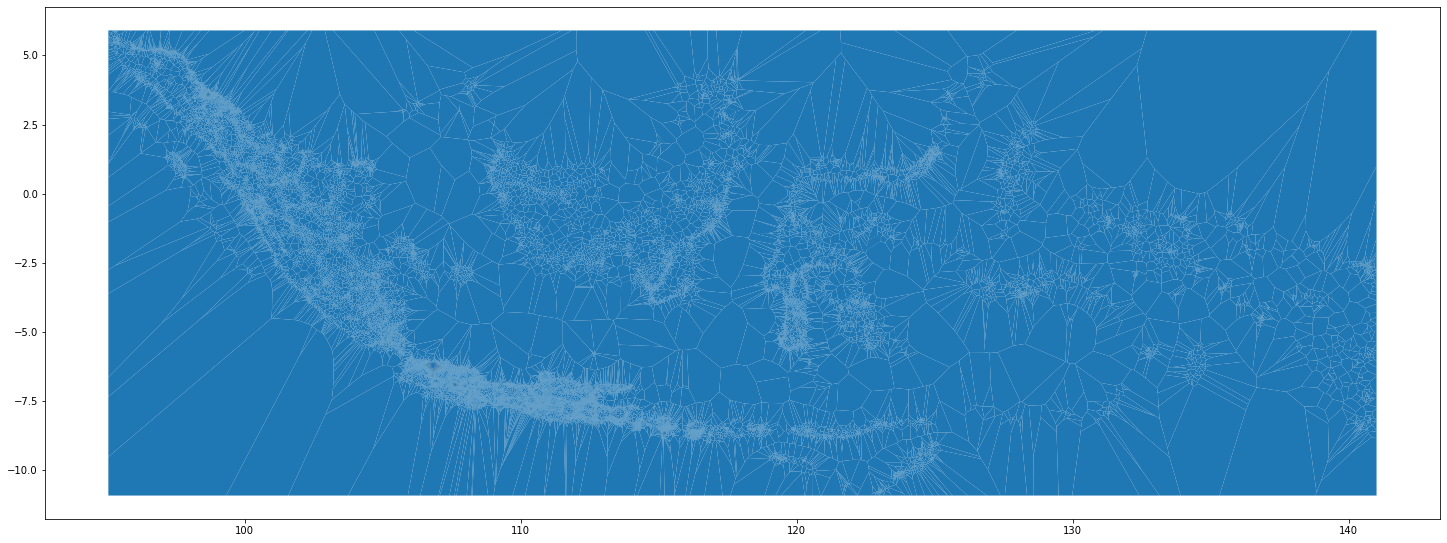

In [7]:
fig, ax = plt.subplots(figsize = (25, 25))
vor.plot(ax = ax)

#### Site Radius Seting

In [8]:
# site location
site_loc = m_voronoi[['longitude_fix','latitude_fix']]
site_centers = gpd.GeoDataFrame(site_loc, geometry=gpd.points_from_xy(site_loc.longitude_fix, site_loc.latitude_fix)) # site center point
site_centers.crs = {'init':'epsg:4326'} # start from globe standard
site_centers = site_centers.to_crs(epsg = '3857') # convert to map calculation (meter)

# set radius
radius_1km = site_centers.geometry.buffer(1000) #meter
radius_1km = radius_1km.to_crs(epsg = '4326')

radius_5km = site_centers.geometry.buffer(5000) #meter
radius_5km = radius_5km.to_crs(epsg = '4326')

#### Intersection-Union Voronoi & Radius

Site coverage either using voronoi(with 5km buffer) or 1km radius from site

In [9]:
# intersect 5km buffer
site_vor = vor.copy()
site_vor['geometry'] = gpd.GeoDataFrame(site_vor['geometry'].intersection(radius_5km), columns = ['geometry'], crs = {'init':'epsg:4326'}, geometry = 'geometry')
site_vor_buffer = gpd.GeoDataFrame(site_vor, crs = {'init': 'epsg:4326'}, geometry = 'geometry')
print(site_vor_buffer.shape)

(62512, 5)


<AxesSubplot:>

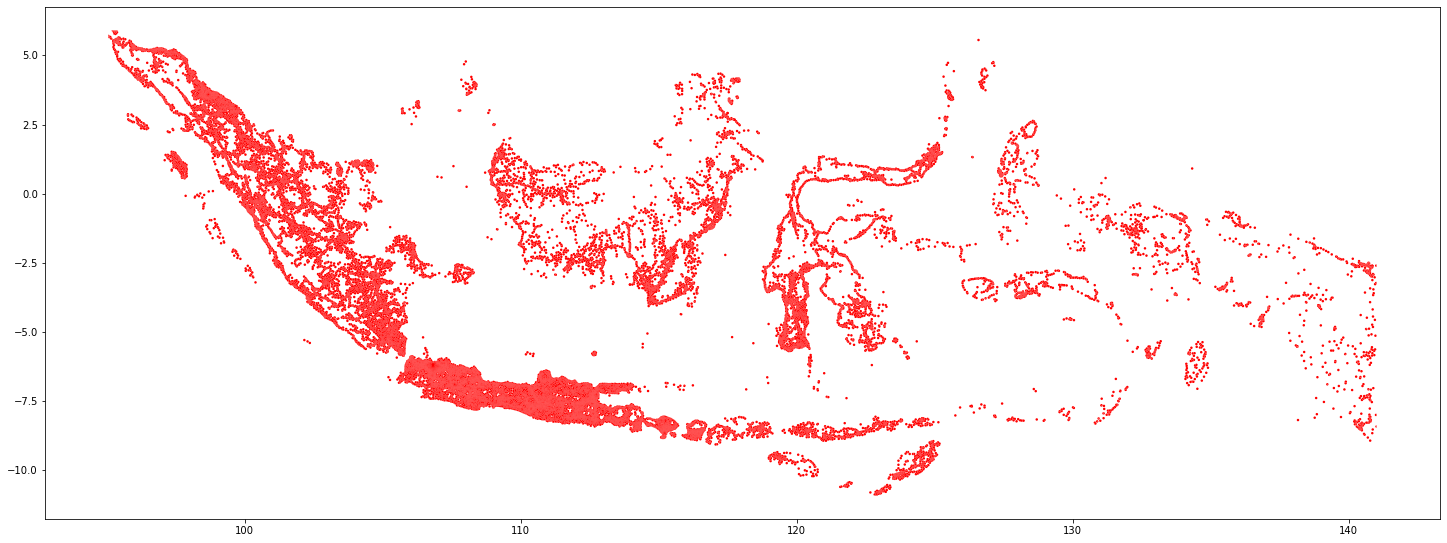

In [10]:
fig, ax = plt.subplots(figsize = (25, 25))
site_vor_buffer.plot(ax = ax, color='red')

In [11]:
# union 1km area
site_area = site_vor_buffer.copy()
site_area['geometry'] = gpd.GeoDataFrame(site_area['geometry'].union(radius_1km), columns = ['geometry'], crs = {'init':'epsg:4326'}, geometry = 'geometry')
site_area = gpd.GeoDataFrame(site_area, crs = {'init': 'epsg:4326'}, geometry = 'geometry')
print(site_area.shape)

(62512, 5)


In [12]:
#calc union area
site_area = site_area.to_crs(epsg = 3857)
site_area['area_km2'] = site_area.area/1000000
site_area = site_area.to_crs(epsg = 4326)
site_area.head()

,yearweek,site_id,longitude_fix,latitude_fix,geometry,area_km2
0,202211,SNB147,96.444570,2.356530,"POLYGON ((96.40390 2.37544, 96.40496 2.37769, ...",32.580564
1,202211,SNB591,96.442881,2.332535,"POLYGON ((96.48686 2.32350, 96.48586 2.31951, ...",48.602343
2,202211,SNB595,96.497705,2.367071,"POLYGON ((96.46936 2.37075, 96.51184 2.40962, ...",55.389919
3,202211,SNB256,96.468201,2.399311,"POLYGON ((96.42329 2.39931, 96.42350 2.40371, ...",48.067704
4,202211,SNB051,96.370010,2.346053,"POLYGON ((96.37986 2.38980, 96.38305 2.38900, ...",56.297435


<AxesSubplot:>

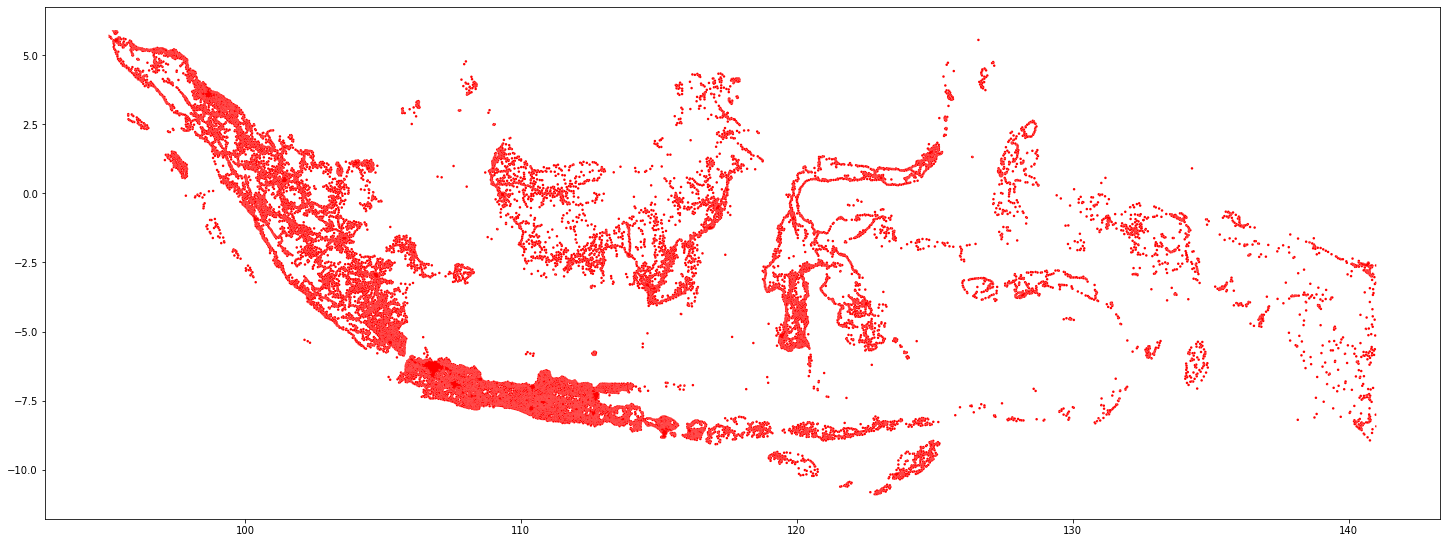

In [13]:
fig, ax = plt.subplots(figsize = (25, 25))
site_area.plot(ax = ax, color='red')

## Prepare Outlet Data

In [14]:
m_outlet = pd.read_csv('geopandas_master_outlet.csv', low_memory=False)

In [15]:
print(m_outlet.shape)
print(m_outlet.isna().sum())
m_outlet.head()

(565120, 3)
id_outlet       1
longitude    1878
lattitude    1878
dtype: int64


,id_outlet,longitude,lattitude
0,NaN,NaN,NaN
1,1100000001,96.242859,5.236326
2,1100000008,95.316113,5.540995
3,1100000009,95.949724,5.379236
4,1100000010,95.960204,5.384539


In [16]:
m_outlet = m_outlet.dropna(subset = ['longitude','lattitude'])
m_outlet = m_outlet[(m_outlet['longitude'] != 0) & (m_outlet['lattitude'] != 0)]

In [17]:
print(m_outlet.shape)
print(m_outlet.isna().sum())
m_outlet.head()

(526432, 3)
id_outlet    0
longitude    0
lattitude    0
dtype: int64


,id_outlet,longitude,lattitude
1,1100000001,96.242859,5.236326
2,1100000008,95.316113,5.540995
3,1100000009,95.949724,5.379236
4,1100000010,95.960204,5.384539
5,1100000012,95.325771,5.515517


In [18]:
outlet_poi = gpd.GeoDataFrame(m_outlet, geometry=gpd.points_from_xy(m_outlet.longitude, m_outlet.lattitude))
outlet_poi.head()

,id_outlet,longitude,lattitude,geometry
1,1100000001,96.242859,5.236326,POINT (96.24286 5.23633)
2,1100000008,95.316113,5.540995,POINT (95.31611 5.54100)
3,1100000009,95.949724,5.379236,POINT (95.94972 5.37924)
4,1100000010,95.960204,5.384539,POINT (95.96020 5.38454)
5,1100000012,95.325771,5.515517,POINT (95.32577 5.51552)


## Prepare Indomaret Alfamart data

In [19]:
m_minimart = pd.read_csv('geopandas_master_indoalfa.csv', low_memory=False)

In [20]:
print(m_minimart.shape)
print(m_minimart.isna().sum())
m_minimart.head()

(36514, 8)
placeid                0
chain_name             0
admin_level_2          9
admin_level_3          0
admin_level_4          0
postal_code            4
display_longitude    761
display_latitude     761
dtype: int64


,placeid,chain_name,admin_level_2,admin_level_3,admin_level_4,postal_code,display_longitude,display_latitude
0,360qqgbv-46c888f340fa4725b4a0326fcb0c1de3,Indomaret,Jawa Barat,Sukabumi,Parung Kuda,43357.0,106.76829,-6.864837
1,360qqgbv-85ed50c695aa4e7c81fccd95d58f8a8c,Indomaret,Jawa Barat,Sukabumi,Cibadak,43351.0,106.77653,-6.877100
2,360jx7ps-17a319f8c79f0fb8a5a43907f3d654cf,Indomaret,Jawa Barat,Sukabumi,Cicantayan,43345.0,106.84927,-6.902292
3,360qr8x7-6fff8be03c6e49a0952c22aba284d33f,Indomaret,Jambi,Bungo,Rimbo Tengah,37217.0,102.10092,-1.497076
4,360jx7ps-0083e5dba1920a95db98773cb92ad1ad,Indomaret,DKI Jakarta,Jakarta,Pancoran,12760.0,106.82685,-6.254180


In [21]:
minimart_poi = gpd.GeoDataFrame(m_minimart, geometry=gpd.points_from_xy(m_minimart.display_longitude, m_minimart.display_latitude))
minimart_poi.head()

,placeid,chain_name,admin_level_2,admin_level_3,admin_level_4,postal_code,display_longitude,display_latitude,geometry
0,360qqgbv-46c888f340fa4725b4a0326fcb0c1de3,Indomaret,Jawa Barat,Sukabumi,Parung Kuda,43357.0,106.76829,-6.864837,POINT (106.76829 -6.86484)
1,360qqgbv-85ed50c695aa4e7c81fccd95d58f8a8c,Indomaret,Jawa Barat,Sukabumi,Cibadak,43351.0,106.77653,-6.877100,POINT (106.77653 -6.87710)
2,360jx7ps-17a319f8c79f0fb8a5a43907f3d654cf,Indomaret,Jawa Barat,Sukabumi,Cicantayan,43345.0,106.84927,-6.902292,POINT (106.84927 -6.90229)
3,360qr8x7-6fff8be03c6e49a0952c22aba284d33f,Indomaret,Jambi,Bungo,Rimbo Tengah,37217.0,102.10092,-1.497076,POINT (102.10092 -1.49708)
4,360jx7ps-0083e5dba1920a95db98773cb92ad1ad,Indomaret,DKI Jakarta,Jakarta,Pancoran,12760.0,106.82685,-6.254180,POINT (106.82685 -6.25418)


## Join Data

### Site Voronoi (with buffer) - Outlet

In [22]:
len(site_vor_buffer), len(outlet_poi)

(62512, 526432)

In [23]:
outlet_site_voronoi = gpd.sjoin(site_vor_buffer,outlet_poi, how='inner')

In [24]:
outlet_site_voronoi = outlet_site_voronoi[['site_id','id_outlet']]

In [25]:
print(outlet_site_voronoi.shape)
print(outlet_site_voronoi.isna().sum())
outlet_site_voronoi.head()

(525562, 2)
site_id      0
id_outlet    0
dtype: int64


,site_id,id_outlet
0,SNB147,1101015527
1,SNB591,6001219706
2,SNB595,1101002084
3,SNB256,1101011795
3,SNB256,1101004689


### Site Voronoi (with buffer) - Minimart

In [26]:
len(site_vor_buffer), len(minimart_poi)

(62512, 36514)

In [27]:
minimart_site_voronoi = gpd.sjoin(site_vor_buffer,minimart_poi, how='inner')

In [28]:
minimart_site_voronoi = minimart_site_voronoi[['site_id', 'chain_name', 'placeid']]

In [29]:
print(minimart_site_voronoi.shape)
print(minimart_site_voronoi.isna().sum())
minimart_site_voronoi.head()

(35794, 3)
site_id       0
chain_name    0
placeid       0
dtype: int64


,site_id,chain_name,placeid
11,SNB064,Indomaret,360w0kw1-de612aaddbc461a859e62619586b60ee
51,SKL544,Indomaret,360w0mt4-061c6f1747ff8f892c38bd5dc6c835da
74,SKL058,Indomaret,360w0mtt-57d1c2fbc2d94b4db50213db1bb78607
111,TTN086,Indomaret,360w0t1w-ad524f42e79e462ab602e6f7b641763b
127,COA057,Indomaret,360w0t4e-c334ac2fc9004ddd95b6fca2173666f2


### Site Area - Outlet

In [30]:
len(site_area), len(outlet_poi)

(62512, 526432)

In [31]:
outlet_site_area = gpd.sjoin(site_area, outlet_poi, how='inner')
outlet_site_area = outlet_site_area[['site_id', 'id_outlet']]

In [32]:
print(outlet_site_area.shape)
print(outlet_site_area.isna().sum())
outlet_site_area.head()

(2585423, 2)
site_id      0
id_outlet    0
dtype: int64


,site_id,id_outlet
0,SNB147,1101015527
1,SNB591,6001219706
2,SNB595,1101002084
3,SNB256,1101011795
3,SNB256,1101004689


### Site Area - Minimart

In [33]:
len(site_area), len(minimart_poi)

(62512, 36514)

In [34]:
minimart_site_area = gpd.sjoin(site_area, minimart_poi, how='inner')
minimart_site_area = minimart_site_area[['site_id', 'chain_name', 'placeid']]

In [35]:
print(minimart_site_area.shape)
print(minimart_site_area.isna().sum())
minimart_site_area.head()

(254007, 3)
site_id       0
chain_name    0
placeid       0
dtype: int64


,site_id,chain_name,placeid
11,SNB064,Indomaret,360w0kw1-de612aaddbc461a859e62619586b60ee
14,SNB050,Indomaret,360w0kw1-de612aaddbc461a859e62619586b60ee
15,SNB053,Indomaret,360w0kw1-de612aaddbc461a859e62619586b60ee
51,SKL544,Indomaret,360w0mt4-061c6f1747ff8f892c38bd5dc6c835da
71,SKL075,Indomaret,360w0mtt-57d1c2fbc2d94b4db50213db1bb78607


# Transaction Analytics

## Prepare Outlet Transaction Data

In [36]:
outlet_transaction = pd.read_csv("analytics_outlet_transaction.csv", low_memory=False)

In [37]:
print(outlet_transaction.shape)
print(outlet_transaction.isna().sum())
outlet_transaction.head()

(565152, 6)
id_outlet       0
pjp             0
rech_reguler    0
rech_package    0
rech_nsb        0
rech_vf         0
dtype: int64


,id_outlet,pjp,rech_reguler,rech_package,rech_nsb,rech_vf
0,1100000001,PJP,0,426000,0,0
1,1100000008,PJP,0,0,0,0
2,1100000009,PJP,66000,29100,0,0
3,1100000010,PJP,55000,131200,0,0
4,1100000012,PJP,11000,485950,0,0


In [38]:
outlet_transaction[outlet_transaction['id_outlet'].duplicated()]

,id_outlet,pjp,rech_reguler,rech_package,rech_nsb,rech_vf
53709,1200014267,PJP,0,0,0,0
53780,1200014369,PJP,0,0,0,0
54231,1200015120,PJP,0,0,0,0
54259,1200015163,PJP,0,20000,0,0
54311,1200015253,PJP,0,0,0,0
54342,1200015308,PJP,0,329000,0,0
54440,1200015489,PJP,0,0,0,0
54473,1200015537,PJP,0,90200,0,0
54522,1200015615,PJP,0,0,0,0
54609,1200015754,PJP,0,0,0,0


In [39]:
outlet_transaction[outlet_transaction['id_outlet'] == '1200015120']

,id_outlet,pjp,rech_reguler,rech_package,rech_nsb,rech_vf
54230,1200015120,NON PJP,0,0,0,0
54231,1200015120,PJP,0,0,0,0


In [40]:
outlet_trx = outlet_transaction[['id_outlet','pjp']]
outlet_trx['rev_outlet'] = (outlet_transaction['rech_reguler'] + outlet_transaction['rech_package'] + outlet_transaction['rech_vf'] + outlet_transaction['rech_nsb'])
outlet_trx['outlet_active'] = np.where(outlet_trx['rev_outlet'] > 0, 'active', 'not_active')

In [41]:
print(outlet_trx.shape)
print(outlet_trx.isna().sum())
outlet_trx.head()

(565152, 4)
id_outlet        0
pjp              0
rev_outlet       0
outlet_active    0
dtype: int64


,id_outlet,pjp,rev_outlet,outlet_active
0,1100000001,PJP,426000,active
1,1100000008,PJP,0,not_active
2,1100000009,PJP,95100,active
3,1100000010,PJP,186200,active
4,1100000012,PJP,496950,active


## Prepare Site Recharge Composition & Detail

In [42]:
site_detail = pd.read_csv('analytics_site_detail.csv', low_memory=False)

In [43]:
print(site_detail.shape)
print(site_detail.isna().sum())
site_detail.head()

(59562, 11)
yearmonth             0
site_id               0
regional              0
kabupaten             0
pop                   0
cb_penetration        0
market_share          0
archetype             0
revenue_total         0
demand_forecast    1448
site_index           97
dtype: int64


,yearmonth,site_id,regional,kabupaten,pop,cb_penetration,market_share,archetype,revenue_total,demand_forecast,site_index
0,202201,COI987,SULAWESI,GOWA,3111,0.091289,37.830002,Grow Fortress,1.694310e+07,NaN,0.353431
1,202201,BKG782,SUMBAGTENG,KAMPAR,1212,0.941419,66.209999,Optimize Fortress,7.126169e+07,NaN,0.135343
2,202201,BJN674,JATENG-DIY,BANJARNEGARA,9886,0.280397,41.259998,Attack in the Middle,1.049052e+08,NaN,0.248574
3,202201,ADL001,SULAWESI,KONAWE SELATAN,3215,1.433904,81.419998,Attack in the Middle,1.883733e+08,2.091752e+08,0.234701
4,202201,ADL003,SULAWESI,BOMBANA,3657,1.330325,95.779999,Attack in the Middle,2.364795e+08,2.516108e+08,0.139894


In [44]:
site_detail = site_detail.fillna(0)

In [45]:
site_recharge = pd.read_csv('analytics_site_rech_composition.csv', low_memory=False)

In [46]:
print(site_recharge.shape)
print(site_recharge.isna().sum())
site_recharge.head()

(65109, 6)
site_id             0
rech_traditional    0
rech_outlet         0
rech_alfamart       0
rech_indomaret      0
total_rech          0
dtype: int64


,site_id,rech_traditional,rech_outlet,rech_alfamart,rech_indomaret,total_rech
0,ADL006,78505741.0,57356741.0,1420000.0,2830000.0,133122491.0
1,ADL008,62540864.0,43500864.0,770000.0,3320000.0,122022864.0
2,ADL011,101935209.0,73918209.0,1685000.0,2445000.0,163761809.0
3,ADL013,121916161.0,64833161.0,2420000.0,21930000.0,247800061.0
4,ADL015,85278386.0,63847386.0,1165000.0,3590000.0,142290136.0


In [47]:
site_detail_rech = site_detail.merge(site_recharge, on='site_id', how='left')

In [48]:
print(site_detail_rech.shape)
print(site_detail_rech.isna().sum())
site_detail_rech.head()

(59562, 16)
yearmonth           0
site_id             0
regional            0
kabupaten           0
pop                 0
cb_penetration      0
market_share        0
archetype           0
revenue_total       0
demand_forecast     0
site_index          0
rech_traditional    2
rech_outlet         2
rech_alfamart       2
rech_indomaret      2
total_rech          2
dtype: int64


,yearmonth,site_id,regional,kabupaten,pop,cb_penetration,market_share,archetype,revenue_total,demand_forecast,site_index,rech_traditional,rech_outlet,rech_alfamart,rech_indomaret,total_rech
0,202201,COI987,SULAWESI,GOWA,3111,0.091289,37.830002,Grow Fortress,1.694310e+07,0.000000e+00,0.353431,4551402.0,3558402.0,80000.0,150000.0,9531402.0
1,202201,BKG782,SUMBAGTENG,KAMPAR,1212,0.941419,66.209999,Optimize Fortress,7.126169e+07,0.000000e+00,0.135343,44103650.0,27137650.0,290000.0,20000.0,60770850.0
2,202201,BJN674,JATENG-DIY,BANJARNEGARA,9886,0.280397,41.259998,Attack in the Middle,1.049052e+08,0.000000e+00,0.248574,39880400.0,13042400.0,2075000.0,380000.0,82208700.0
3,202201,ADL001,SULAWESI,KONAWE SELATAN,3215,1.433904,81.419998,Attack in the Middle,1.883733e+08,2.091752e+08,0.234701,96779067.0,59291067.0,1660000.0,4775000.0,205126017.0
4,202201,ADL003,SULAWESI,BOMBANA,3657,1.330325,95.779999,Attack in the Middle,2.364795e+08,2.516108e+08,0.139894,122041310.0,101663310.0,1105000.0,8040000.0,213931110.0


In [49]:
site_detail_rech.columns

Index(['yearmonth', 'site_id', 'regional', 'kabupaten', 'pop',
       'cb_penetration', 'market_share', 'archetype', 'revenue_total',
       'demand_forecast', 'site_index', 'rech_traditional', 'rech_outlet',
       'rech_alfamart', 'rech_indomaret', 'total_rech'],
      dtype='object')

In [50]:
site_detail_rech = site_detail_rech[['site_id',
                                     'regional',
                                     'kabupaten',
                                     'archetype',
                                     'pop',
                                     'cb_penetration',
                                     'market_share',
                                     'revenue_total',
                                     'demand_forecast',
                                     'site_index',
                                     'total_rech',
                                     'rech_traditional',
                                     'rech_outlet',
                                     'rech_alfamart',
                                     'rech_indomaret']]

In [51]:
site_detail_rech.head()

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,total_rech,rech_traditional,rech_outlet,rech_alfamart,rech_indomaret
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,9531402.0,4551402.0,3558402.0,80000.0,150000.0
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,60770850.0,44103650.0,27137650.0,290000.0,20000.0
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,82208700.0,39880400.0,13042400.0,2075000.0,380000.0
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,205126017.0,96779067.0,59291067.0,1660000.0,4775000.0
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,213931110.0,122041310.0,101663310.0,1105000.0,8040000.0


## Prepare Minimart site Area

In [52]:
site_minimart_count = minimart_site_area.pivot_table(
    index='site_id',
    columns='chain_name',
    values='placeid',
    aggfunc='count',
    fill_value=0).fillna(0).rename(columns={'Indomaret': 'count_idm', 'ALFAMART': 'count_alfa'}).reset_index()

In [53]:
print(site_minimart_count.shape)
print(site_minimart_count.isna().sum())
site_minimart_count.head()

(30949, 3)
chain_name
site_id       0
count_alfa    0
count_idm     0
dtype: int64


chain_name,site_id,count_alfa,count_idm
0,ADL001,0,1
1,ADL005,0,2
2,ADL007,0,1
3,ADL011,0,1
4,ADL013,0,1


# df creation

## df_1 [site & outlet voronoi (buffer 5km) & minimart voronoi (buffer + radius 1km)]

### join outlet site voronoi & outlet trx

In [54]:
len(outlet_site_voronoi), len(outlet_trx)

(525562, 565152)

In [55]:
site_outlet_trx = outlet_site_voronoi.merge(outlet_trx, on='id_outlet', how='left')

In [56]:
print(site_outlet_trx.shape)
print(site_outlet_trx.isna().sum())
site_outlet_trx.head()

(525595, 5)
site_id          0
id_outlet        0
pjp              0
rev_outlet       0
outlet_active    0
dtype: int64


,site_id,id_outlet,pjp,rev_outlet,outlet_active
0,SNB147,1101015527,PJP,120199,active
1,SNB591,6001219706,NON PJP,0,not_active
2,SNB595,1101002084,PJP,594996,active
3,SNB256,1101011795,NON PJP,71699,active
4,SNB256,1101004689,PJP,241398,active


In [57]:
site_outlet_trx_count = site_outlet_trx.pivot_table(
    index='site_id',
    columns='pjp',
    values='id_outlet',
    aggfunc='count',
    fill_value=0).fillna(0).rename(columns={'NON PJP': 'out_non_pjp', 'PJP': 'out_pjp'}).reset_index()
site_outlet_trx_count['total_outlet'] = (site_outlet_trx_count['out_non_pjp'] + site_outlet_trx_count['out_pjp'])

site_outlet_trx_active = site_outlet_trx.pivot_table(
    index='site_id',
    columns='outlet_active',
    values='id_outlet',
    aggfunc='count',
    fill_value=0).fillna(0).rename(columns={'active': 'out_active'}).reset_index()
site_outlet_trx_active = site_outlet_trx_active.drop(['not_active'], axis=1)

site_outlet_trx_sum = site_outlet_trx.pivot_table(
    index='site_id',
    columns='pjp',
    values='rev_outlet',
    aggfunc='sum',
    fill_value=0).rename(columns={'NON PJP': 'rev_non_pjp', 'PJP': 'rev_pjp'}).reset_index()

site_outlet_trx_final = site_outlet_trx_count.merge(site_outlet_trx_active, on='site_id', how='left').merge(site_outlet_trx_sum, on='site_id', how='left')

In [58]:
print(site_outlet_trx_final.shape)
print(site_outlet_trx_final.isna().sum())
site_outlet_trx_final.head()

(55503, 7)
site_id         0
out_non_pjp     0
out_pjp         0
total_outlet    0
out_active      0
rev_non_pjp     0
rev_pjp         0
dtype: int64


,site_id,out_non_pjp,out_pjp,total_outlet,out_active,rev_non_pjp,rev_pjp
0,ADL001,6,7,13,4,0,2323050
1,ADL003,124,28,152,46,2049396,5454739
2,ADL005,25,13,38,19,352100,6705300
3,ADL006,7,3,10,4,228400,251800
4,ADL007,14,12,26,12,428100,4098350


In [59]:
site_outlet_trx = site_outlet_trx_final[['site_id','total_outlet','out_pjp','out_active']]
site_outlet_trx['total_rev_out'] = site_outlet_trx_final['rev_pjp'] + site_outlet_trx_final['rev_non_pjp']
site_outlet_trx['rev_out_pjp'] = site_outlet_trx_final['rev_pjp']

In [60]:
print(site_outlet_trx.shape)
print(site_outlet_trx.isna().sum())
site_outlet_trx.head()

(55503, 6)
site_id          0
total_outlet     0
out_pjp          0
out_active       0
total_rev_out    0
rev_out_pjp      0
dtype: int64


,site_id,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp
0,ADL001,13,7,4,2323050,2323050
1,ADL003,152,28,46,7504135,5454739
2,ADL005,38,13,19,7057400,6705300
3,ADL006,10,3,4,480200,251800
4,ADL007,26,12,12,4526450,4098350


### add minimart

In [61]:
len(site_outlet_trx), len(site_minimart_count), len(site_detail_rech)

(55503, 30949, 59562)

In [62]:
df1 = site_detail_rech.merge(site_outlet_trx, on='site_id', how='left').merge(site_minimart_count, on='site_id', how='left')

In [63]:
df1.head(100)

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_outlet,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,3558402.0,80000.0,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,NaN,NaN
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,27137650.0,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,NaN,NaN
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,13042400.0,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,NaN,NaN
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,59291067.0,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,101663310.0,1105000.0,8040000.0,152.0,28.0,46.0,7504135.0,5454739.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ADL109,SULAWESI,KONAWE SELATAN,Optimize Fortress,1065,1.392488,81.419998,9.575312e+07,1.221451e+08,0.156916,...,17681832.0,610000.0,458000.0,4.0,1.0,0.0,0.0,0.0,NaN,NaN
96,ADL110,SULAWESI,KONAWE SELATAN,Optimize Fortress,1746,1.254868,81.419998,1.174325e+08,1.534509e+08,0.182933,...,44616692.0,750000.0,8425000.0,14.0,12.0,11.0,3705500.0,3619400.0,0.0,1.0
97,ADL111,SULAWESI,BOMBANA,Optimize Fortress,1487,1.948218,95.779999,1.274224e+08,1.531168e+08,0.192756,...,74017756.0,570000.0,2530000.0,26.0,6.0,7.0,2167239.0,2020890.0,NaN,NaN
98,ADL112,SULAWESI,BOMBANA,Optimize Fortress,547,6.404022,95.779999,1.653535e+08,2.009002e+08,0.374631,...,85158449.0,910000.0,6180000.0,65.0,19.0,20.0,8675664.0,7578384.0,0.0,2.0


## df_2 [site & outlet voronoi (buffer + radius 1km) & minimart voronoi (buffer + radius 1km)]

### join outlet site area & outlet trx

In [64]:
len(outlet_site_area), len(outlet_trx)

(2585423, 565152)

In [65]:
site_outlet_area_trx = outlet_site_area.merge(outlet_trx, on='id_outlet', how='left')

In [66]:
print(site_outlet_area_trx.shape)
print(site_outlet_area_trx.isna().sum())
site_outlet_area_trx.head()

(2585570, 5)
site_id          0
id_outlet        0
pjp              0
rev_outlet       0
outlet_active    0
dtype: int64


,site_id,id_outlet,pjp,rev_outlet,outlet_active
0,SNB147,1101015527,PJP,120199,active
1,SNB591,6001219706,NON PJP,0,not_active
2,SNB595,1101002084,PJP,594996,active
3,SNB256,1101011795,NON PJP,71699,active
4,SNB256,1101004689,PJP,241398,active


In [67]:
site_outlet_area_trx_count = site_outlet_area_trx.pivot_table(
    index='site_id',
    columns='pjp',
    values='id_outlet',
    aggfunc='count',
    fill_value=0).fillna(0).rename(columns={'NON PJP': 'out_non_pjp', 'PJP': 'out_pjp'}).reset_index()
site_outlet_area_trx_count['total_outlet'] = (site_outlet_area_trx_count['out_non_pjp'] + site_outlet_area_trx_count['out_pjp'])

site_outlet_area_trx_active = site_outlet_area_trx.pivot_table(
    index='site_id',
    columns='outlet_active',
    values='id_outlet',
    aggfunc='count',
    fill_value=0).fillna(0).rename(columns={'active': 'out_active'}).reset_index()
site_outlet_area_trx_active = site_outlet_area_trx_active.drop(['not_active'], axis=1)

site_outlet_area_trx_sum = site_outlet_area_trx.pivot_table(
    index='site_id',
    columns='pjp',
    values='rev_outlet',
    aggfunc='sum',
    fill_value=0).rename(columns={'NON PJP': 'rev_non_pjp', 'PJP': 'rev_pjp'}).reset_index()

site_outlet_area_trx_final = site_outlet_area_trx_count.merge(site_outlet_area_trx_active, on='site_id', how='left').merge(site_outlet_area_trx_sum, on='site_id', how='left')

In [68]:
print(site_outlet_area_trx_final.shape)
print(site_outlet_area_trx_final.isna().sum())
site_outlet_area_trx_final.head()

(59992, 7)
site_id         0
out_non_pjp     0
out_pjp         0
total_outlet    0
out_active      0
rev_non_pjp     0
rev_pjp         0
dtype: int64


,site_id,out_non_pjp,out_pjp,total_outlet,out_active,rev_non_pjp,rev_pjp
0,ADL001,6,7,13,4,0,2323050
1,ADL003,163,44,207,63,3086676,12639124
2,ADL005,39,24,63,32,810050,9634000
3,ADL006,8,3,11,4,228400,251800
4,ADL007,14,12,26,12,428100,4098350


In [69]:
site_outlet_area_trx = site_outlet_area_trx_final[['site_id','total_outlet','out_pjp','out_active']]
site_outlet_area_trx['total_rev_out'] = site_outlet_area_trx_final['rev_pjp'] + site_outlet_area_trx_final['rev_non_pjp']
site_outlet_area_trx['rev_out_pjp'] = site_outlet_area_trx_final['rev_pjp']

In [70]:
print(site_outlet_area_trx.shape)
print(site_outlet_area_trx.isna().sum())
site_outlet_area_trx.head()

(59992, 6)
site_id          0
total_outlet     0
out_pjp          0
out_active       0
total_rev_out    0
rev_out_pjp      0
dtype: int64


,site_id,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp
0,ADL001,13,7,4,2323050,2323050
1,ADL003,207,44,63,15725800,12639124
2,ADL005,63,24,32,10444050,9634000
3,ADL006,11,3,4,480200,251800
4,ADL007,26,12,12,4526450,4098350


### add minimart

In [71]:
df2 = site_detail_rech.merge(site_outlet_area_trx, on='site_id', how='left').merge(site_minimart_count, on='site_id', how='left')

In [72]:
df2.head(100)

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_outlet,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,3558402.0,80000.0,150000.0,67.0,33.0,24.0,8074870.0,8004470.0,NaN,NaN
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,27137650.0,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,NaN,NaN
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,13042400.0,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,NaN,NaN
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,59291067.0,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,101663310.0,1105000.0,8040000.0,207.0,44.0,63.0,15725800.0,12639124.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ADL109,SULAWESI,KONAWE SELATAN,Optimize Fortress,1065,1.392488,81.419998,9.575312e+07,1.221451e+08,0.156916,...,17681832.0,610000.0,458000.0,4.0,1.0,0.0,0.0,0.0,NaN,NaN
96,ADL110,SULAWESI,KONAWE SELATAN,Optimize Fortress,1746,1.254868,81.419998,1.174325e+08,1.534509e+08,0.182933,...,44616692.0,750000.0,8425000.0,15.0,13.0,12.0,3817500.0,3731400.0,0.0,1.0
97,ADL111,SULAWESI,BOMBANA,Optimize Fortress,1487,1.948218,95.779999,1.274224e+08,1.531168e+08,0.192756,...,74017756.0,570000.0,2530000.0,31.0,6.0,8.0,2287239.0,2020890.0,NaN,NaN
98,ADL112,SULAWESI,BOMBANA,Optimize Fortress,547,6.404022,95.779999,1.653535e+08,2.009002e+08,0.374631,...,85158449.0,910000.0,6180000.0,282.0,71.0,92.0,25561919.0,21922143.0,0.0,2.0


# Optimum Outlet df1

In [73]:
print(df1.shape)
print(df1.isna().sum())
df1.head()

(59562, 22)
site_id                 0
regional                0
kabupaten               0
archetype               0
pop                     0
cb_penetration          0
market_share            0
revenue_total           0
demand_forecast         0
site_index              0
total_rech              2
rech_traditional        2
rech_outlet             2
rech_alfamart           2
rech_indomaret          2
total_outlet         5696
out_pjp              5696
out_active           5696
total_rev_out        5696
rev_out_pjp          5696
count_alfa          28990
count_idm           28990
dtype: int64


,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_outlet,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,3558402.0,80000.0,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,NaN,NaN
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,27137650.0,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,NaN,NaN
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,13042400.0,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,NaN,NaN
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,59291067.0,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,101663310.0,1105000.0,8040000.0,152.0,28.0,46.0,7504135.0,5454739.0,NaN,NaN


In [74]:
df1 = df1.fillna(0)

In [75]:
print(df1.shape)
print(df1.isna().sum())
df1.head()

(59562, 22)
site_id             0
regional            0
kabupaten           0
archetype           0
pop                 0
cb_penetration      0
market_share        0
revenue_total       0
demand_forecast     0
site_index          0
total_rech          0
rech_traditional    0
rech_outlet         0
rech_alfamart       0
rech_indomaret      0
total_outlet        0
out_pjp             0
out_active          0
total_rev_out       0
rev_out_pjp         0
count_alfa          0
count_idm           0
dtype: int64


,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_outlet,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,3558402.0,80000.0,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,0.0,0.0
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,27137650.0,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,0.0,0.0
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,13042400.0,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,0.0,0.0
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,59291067.0,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,101663310.0,1105000.0,8040000.0,152.0,28.0,46.0,7504135.0,5454739.0,0.0,0.0


In [76]:
df1.columns

Index(['site_id', 'regional', 'kabupaten', 'archetype', 'pop',
       'cb_penetration', 'market_share', 'revenue_total', 'demand_forecast',
       'site_index', 'total_rech', 'rech_traditional', 'rech_outlet',
       'rech_alfamart', 'rech_indomaret', 'total_outlet', 'out_pjp',
       'out_active', 'total_rev_out', 'rev_out_pjp', 'count_alfa',
       'count_idm'],
      dtype='object')

In [77]:
df1_clustering = df1[[#'site_id',
                      #'regional',
                      #'kabupaten',
                      #'archetype',
                      'pop',
                      'cb_penetration',
                      'market_share',
                      'revenue_total',
                      'demand_forecast',
                      'site_index',
                      'total_rech',
                      'rech_traditional',
                      'rech_outlet',
                      'rech_alfamart',
                      'rech_indomaret',
                      'total_outlet',
                      'out_pjp',
                      'out_active',
                      'total_rev_out',
                      'rev_out_pjp',
                      'count_alfa',
                      'count_idm'
]]

<AxesSubplot:title={'center':'Pearson Correlation'}>

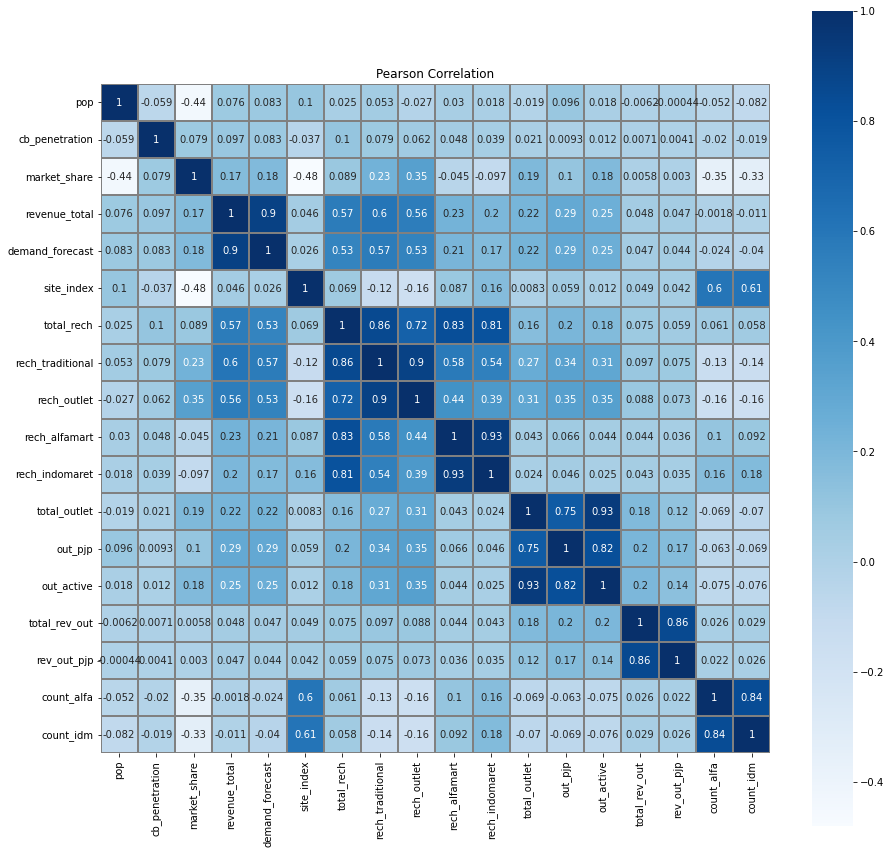

In [78]:
#feature_correlation
f, ax = plt.subplots(figsize=(15, 15))
plt.title('Pearson Correlation')

sns.heatmap(df1_clustering.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, annot=True, cmap="Blues", linecolor='gray')

## Clustering Site Index

In [79]:
# based on discusion with sales team, need poi diferentiation (using site index)
df1_clustering = df1[[#'site_id',
    #'regional',
    #'kabupaten',
    #'archetype',
    #'pop',
    #'cb_penetration',
    #'market_share',
    #'revenue_total',
    #'demand_forecast',
    'site_index'#,
    #'total_rech',
    #'rech_traditional',
    #'rech_outlet',
    #'rech_alfamart',
    #'rech_indomaret',
    #'total_outlet',
    #'out_pjp',
    #'out_active',
    #'total_rev_out',
    #'rev_out_pjp',
    #'count_alfa',
    #'count_idm'
]]

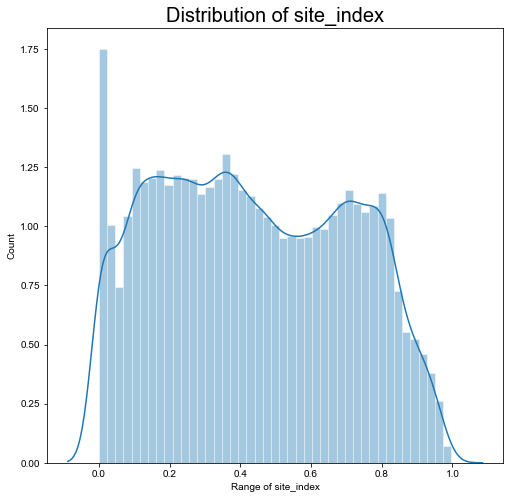

In [80]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(df1_clustering['site_index'])
plt.title('Distribution of site_index', fontsize = 20)
plt.xlabel('Range of site_index')
plt.ylabel('Count')
plt.show()

In [81]:
#elbow
inertia = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df1_clustering)
    kmeanModel.fit(df1_clustering)
    inertia.append(kmeanModel.inertia_)

centroids = pd.DataFrame({'Clusters' : K, 'Inertia' : inertia})
centroids

,Clusters,Inertia
0,1,4192.208651
1,2,1065.346810
2,3,484.177118
3,4,286.957804
4,5,187.965065
5,6,131.480890
6,7,99.012364
7,8,75.844087
8,9,58.418975
9,10,47.212830


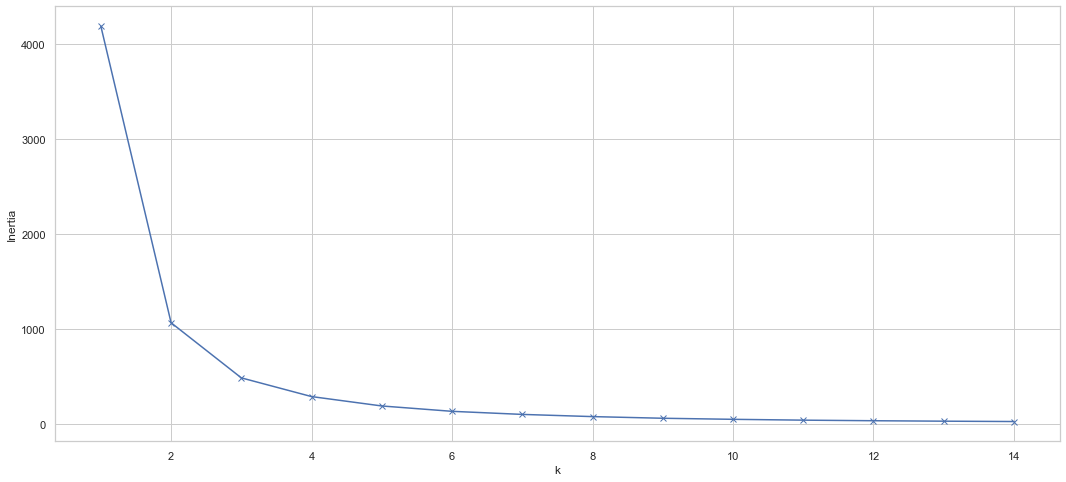

In [82]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [83]:
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(df1_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(df1_clustering, labels, metric = 'euclidean'))

sil01= pd.DataFrame(sil)
sil01.index = sil01.index + 2
sil01

,0
2,0.626266
3,0.587462
4,0.557744
5,0.543913
6,0.539894
7,0.530484
8,0.528832
9,0.537025
10,0.535834


In [84]:
kf = 3
kmeans_f = KMeans(n_clusters=kf).fit(df1_clustering)

In [85]:
labels_f = pd.DataFrame(kmeans_f.labels_)
df1_clustered = pd.concat((df1,labels_f),axis=1)
df1_clustered = df1_clustered.rename({0:'site_index_group'},axis=1)
df1_clustered

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm,site_index_group
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,80000.0,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,0.0,0.0,0
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,0.0,0.0,2
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,0.0,0.0,2
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0,2
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,1105000.0,8040000.0,152.0,28.0,46.0,7504135.0,5454739.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59557,PGA041,SUMBAGSEL,KOTA PAGAR ALAM,Grow Battleground,6073,0.453483,58.130001,8.279178e+07,0.000000e+00,0.739543,...,1070000.0,1350000.0,156.0,82.0,61.0,68549718.0,67659008.0,3.0,4.0,1
59558,LRT116,BALI NUSRA,FLORES TIMUR,Attack in the Middle,3483,0.564169,97.739998,1.047411e+08,0.000000e+00,0.169064,...,950000.0,75000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
59559,RHA082,SULAWESI,MUNA,Attack in the Middle,2974,0.354741,86.260002,6.739868e+07,0.000000e+00,0.084436,...,535000.0,100000.0,1.0,0.0,1.0,166200.0,0.0,0.0,0.0,2
59560,SBW279,BALI NUSRA,SUMBAWA,Attack in the Middle,2861,0.532681,69.040001,5.076943e+07,0.000000e+00,0.322606,...,3535000.0,1670000.0,28.0,12.0,13.0,2587820.0,2522820.0,2.0,1.0,0


In [86]:
df1_clustered.groupby('site_index_group').agg({'site_index':'count'})

,site_index
site_index_group,
0,19896
1,19628
2,20038


In [87]:
df1_clustered['site_index_group'] = df1_clustered['site_index_group'].mask(df1_clustered['site_index_group'] == 0, 'site_index 1')
df1_clustered['site_index_group'] = df1_clustered['site_index_group'].mask(df1_clustered['site_index_group'] == 1, 'site_index 2')
df1_clustered['site_index_group'] = df1_clustered['site_index_group'].mask(df1_clustered['site_index_group'] == 2, 'site_index 3')
df1_clustered.head()

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm,site_index_group
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,80000.0,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,0.0,0.0,site_index 1
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,0.0,0.0,site_index 3
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,0.0,0.0,site_index 3
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0,site_index 3
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,1105000.0,8040000.0,152.0,28.0,46.0,7504135.0,5454739.0,0.0,0.0,site_index 3


In [88]:
df1_clustered.groupby('site_index_group').apply(lambda x: x.describe())

pop  cb_penetration  market_share  \
site_index_group                                                      
site_index 1     count   19896.000000    19896.000000  19896.000000   
                 mean     5475.524176        2.246212     46.737447   
                 std      4756.011576       19.253532     20.485702   
                 min         1.000000        0.003523     17.590000   
                 25%      1976.000000        0.302375     30.719999   
                 50%      4222.500000        0.559536     39.799999   
                 75%      7770.250000        1.184787     58.660000   
                 max    100766.000000     1355.000000     99.449997   
site_index 2     count   19628.000000    19628.000000  19628.000000   
                 mean     3635.866110        2.469530     40.457000   
                 std      2975.865185       44.671606     14.162732   
                 min         1.000000        0.005122     17.590000   
                 25%      1665.000000        0.460908     31.190001   
                 50%      2954.000000        0.752122     35.970001   
                 75%      4743.250000        1.372983     45.320000   
                 max     44222.000000     4674.333333     99.349998   
site_index 3     count   20038.000000    20038.000000  20038.000000   
                 mean     2706.286955        5.707167     64.595605   
                 std      2884.072410       66.466159     21.677751   
                 min         1.000000        0.003190     17.590000   
                 25%       923.250000        0.523152     45.669998   
                 50%      1950.000000        0.992130     64.489998   
                 75%      3572.750000        2.090536     82.699997   
                 max    162461.000000     4358.000000    100.000000   

                        revenue_total  demand_forecast    site_index  \
site_index_group                                                       
site_index 1     count   1.989600e+04     1.989600e+04  19896.000000   
                 mean    1.124142e+08     1.258697e+08      0.429223   
                 std     6.622241e+07     6.747161e+07      0.086937   
                 min     0.000000e+00     0.000000e+00      0.284202   
                 25%     6.755453e+07     8.003777e+07      0.354695   
                 50%     9.982941e+07     1.168764e+08      0.423846   
                 75%     1.426844e+08     1.640336e+08      0.502325   
                 max     1.069576e+09     1.133858e+09      0.589832   
site_index 2     count   1.962800e+04     1.962800e+04  19628.000000   
                 mean    1.198374e+08     1.315380e+08      0.752061   
                 std     6.984294e+07     6.849502e+07      0.097548   
                 min     2.226193e+04    -1.630542e+06      0.589862   
                 25%     7.189676e+07     8.134479e+07      0.671977   
                 50%     1.074520e+08     1.212513e+08      0.745874   
                 75%     1.546796e+08     1.727863e+08      0.821314   
                 max     3.029936e+09     1.707886e+09      0.996884   
site_index 3     count   2.003800e+04     2.003800e+04  20038.000000   
                 mean    1.126705e+08     1.273873e+08      0.140747   
                 std     7.162972e+07     7.465054e+07      0.085660   
                 min     0.000000e+00     0.000000e+00      0.000000   
                 25%     6.298797e+07     7.555031e+07      0.072907   
                 50%     9.759198e+07     1.177537e+08      0.144439   
                 75%     1.441908e+08     1.726318e+08      0.214272   
                 max     8.737074e+08     7.566629e+08      0.284187   

                          total_rech  rech_traditional   rech_outlet  \
site_index_group                                                       
site_index 1     count  1.989600e+04      1.989600e+04  1.989600e+04   
                 mean   1.103407e+08      5.269557e+07  2.743011e+07   
                 std    1.

## Optimum Outlet

In [89]:
df1_clustered.head()

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm,site_index_group
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,80000.0,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,0.0,0.0,site_index 1
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,0.0,0.0,site_index 3
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,0.0,0.0,site_index 3
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0,site_index 3
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,1105000.0,8040000.0,152.0,28.0,46.0,7504135.0,5454739.0,0.0,0.0,site_index 3


In [90]:
display(df1_clustered.groupby('site_index_group').agg({'site_index':'count'}))
display(df1_clustered.groupby('archetype').agg({'site_index':'count'}))

,site_index
site_index_group,
site_index 1,19896
site_index 2,19628
site_index 3,20038


,site_index
archetype,
Attack in the Middle,19716
Expand Battleground,8975
Grow Battleground,4502
Grow Fortress,7937
Optimize Fortress,18432


In [91]:
cols = ['out_active', 'total_rev_out', 'revenue_total', 'demand_forecast', 'total_rech', 'pop']

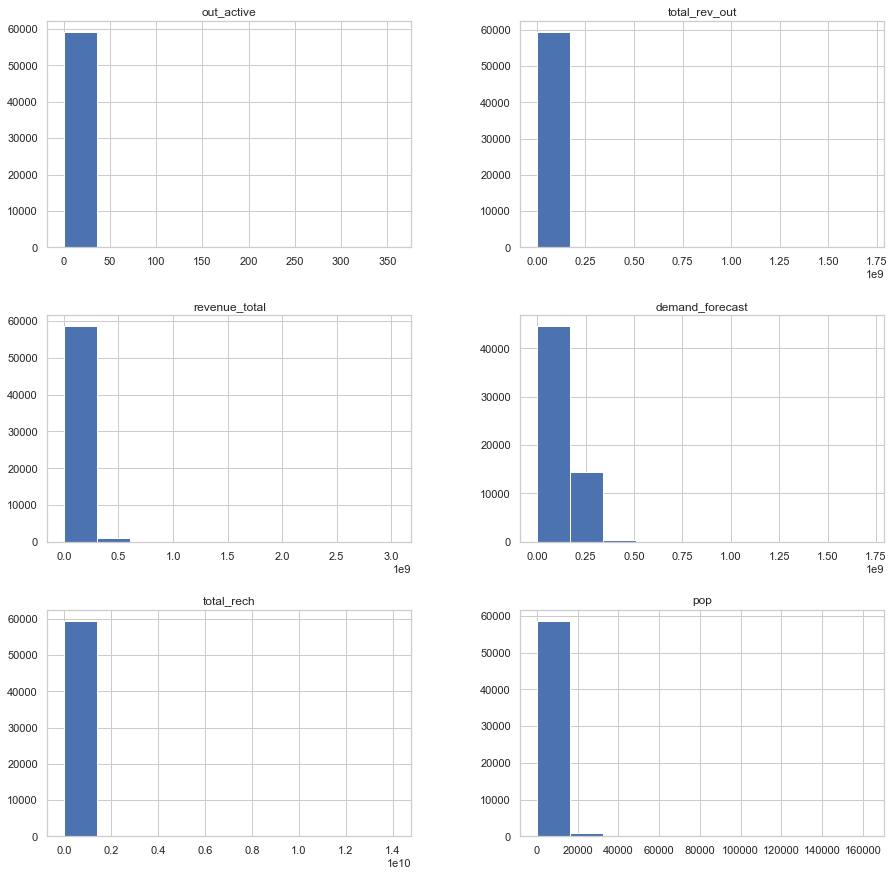

In [92]:
%matplotlib inline
eda = df1_clustered[cols]
eda.hist(figsize=(15,15))
plt.show()

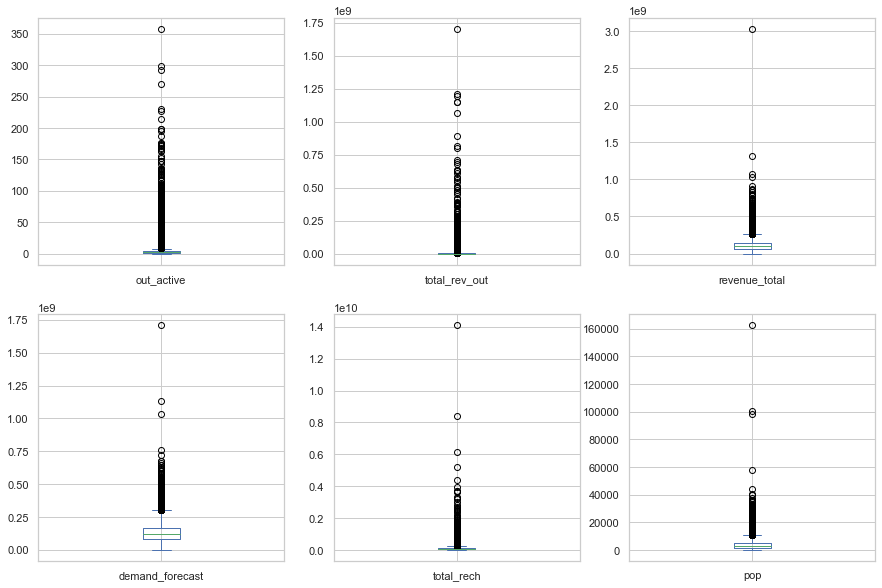

In [93]:
eda.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(15,10), layout=(2,3))
plt.show()

In [94]:
#remove outlier
Q1 = df1_clustered[cols].quantile(0.25)
Q3 = df1_clustered[cols].quantile(0.75)
IQR = Q3 - Q1

df1_final = df1_clustered[~((df1_clustered[cols] < (Q1 - 1.5 * IQR)) |(df1_clustered[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [95]:
print(df1_final.shape)
print(df1_final.isna().sum())
df1_final.head()

(46712, 23)
site_id             0
regional            0
kabupaten           0
archetype           0
pop                 0
cb_penetration      0
market_share        0
revenue_total       0
demand_forecast     0
site_index          0
total_rech          0
rech_traditional    0
rech_outlet         0
rech_alfamart       0
rech_indomaret      0
total_outlet        0
out_pjp             0
out_active          0
total_rev_out       0
rev_out_pjp         0
count_alfa          0
count_idm           0
site_index_group    0
dtype: int64


,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_alfamart,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm,site_index_group
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,80000.0,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,0.0,0.0,site_index 1
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,290000.0,20000.0,7.0,0.0,2.0,171000.0,0.0,0.0,0.0,site_index 3
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,2075000.0,380000.0,5.0,5.0,2.0,685700.0,685700.0,0.0,0.0,site_index 3
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,1660000.0,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0,site_index 3
6,ADL006,SULAWESI,BOMBANA,Optimize Fortress,2693,1.139250,95.779999,1.443760e+08,1.646590e+08,0.174907,...,1420000.0,2830000.0,10.0,3.0,4.0,480200.0,251800.0,0.0,0.0,site_index 3


In [96]:
df1_final = df1_final[df1_final['out_active']>0]
df1_final['avg_rev_out'] = df1_final['total_rev_out']/df1_final['out_active']

In [97]:
df1_loop = df1_final.groupby(['archetype','kabupaten','site_index_group','out_active'], as_index=False).agg({'avg_rev_out':'mean'})

In [98]:
df1_loop.head(20)

,archetype,kabupaten,site_index_group,out_active,avg_rev_out
0,Attack in the Middle,ACEH BARAT,site_index 1,1.0,754645.000000
1,Attack in the Middle,ACEH BARAT,site_index 1,2.0,176072.750000
2,Attack in the Middle,ACEH BARAT,site_index 1,3.0,249101.583333
3,Attack in the Middle,ACEH BARAT,site_index 1,4.0,153061.000000
4,Attack in the Middle,ACEH BARAT,site_index 1,7.0,173701.714286
5,Attack in the Middle,ACEH BARAT,site_index 2,2.0,43099.500000
6,Attack in the Middle,ACEH BARAT,site_index 2,3.0,80707.333333
7,Attack in the Middle,ACEH BARAT,site_index 2,7.0,287984.285714
8,Attack in the Middle,ACEH BARAT,site_index 3,1.0,23799.000000
9,Attack in the Middle,ACEH BARAT,site_index 3,2.0,131247.000000


In [99]:
#looping optimum outlet per city, archetype and site_index cluster
city = df1_loop['kabupaten'].unique()
archetype = df1_loop['archetype'].unique()
site_index = df1_loop['site_index_group'].unique()

optimum_per_city=[]
for i in city:
    df_filter = df1_loop[df1_loop['kabupaten']=='{}'.format(i)]
    for j in archetype:
        df_filter2 = df_filter[df_filter['archetype']=='{}'.format(j)]
        for k in site_index:
            df_filter3 = df_filter2[df_filter2['site_index_group']=='{}'.format(k)]
            df_fin = df_filter3[df_filter3['avg_rev_out']==df_filter3['avg_rev_out'].max()]
            optimum_per_city.append(df_fin)

In [100]:
df1_optimum_per_city = pd.concat(optimum_per_city)
df1_optimum_per_city = df1_optimum_per_city.drop(['avg_rev_out'], axis=1)
df1_optimum_per_city = df1_optimum_per_city[['archetype','kabupaten','site_index_group','out_active']]
df1_optimum_per_city = df1_optimum_per_city.rename({'out_active': 'optimum_outlet'}, axis=1)

In [101]:
df1_optimum_per_city.head(50)

,archetype,kabupaten,site_index_group,optimum_outlet
0,Attack in the Middle,ACEH BARAT,site_index 1,1.0
7,Attack in the Middle,ACEH BARAT,site_index 2,7.0
9,Attack in the Middle,ACEH BARAT,site_index 3,2.0
5659,Grow Fortress,ACEH BARAT,site_index 1,1.0
7913,Optimize Fortress,ACEH BARAT,site_index 1,1.0
7919,Optimize Fortress,ACEH BARAT,site_index 2,3.0
7925,Optimize Fortress,ACEH BARAT,site_index 3,4.0
15,Attack in the Middle,ACEH BARAT DAYA,site_index 1,5.0
16,Attack in the Middle,ACEH BARAT DAYA,site_index 2,4.0
17,Attack in the Middle,ACEH BARAT DAYA,site_index 3,2.0


In [130]:
df1_final = df1_clustered.merge(df1_optimum_per_city, on=['archetype','kabupaten','site_index_group'], how='left').fillna({"optimum_outlet":0})

In [131]:
df1_final.head()

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_indomaret,total_outlet,out_pjp,out_active,total_rev_out,rev_out_pjp,count_alfa,count_idm,site_index_group,optimum_outlet
0,COI987,SULAWESI,GOWA,Grow Fortress,3111,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,150000.0,14.0,9.0,6.0,2507460.0,2507460.0,0.0,0.0,site_index 1,5.0
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,20000.0,7.0,0.0,2.0,171000.0,0.0,0.0,0.0,site_index 3,2.0
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,380000.0,5.0,5.0,2.0,685700.0,685700.0,0.0,0.0,site_index 3,2.0
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,4775000.0,13.0,7.0,4.0,2323050.0,2323050.0,0.0,1.0,site_index 3,4.0
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,8040000.0,152.0,28.0,46.0,7504135.0,5454739.0,0.0,0.0,site_index 3,4.0


In [104]:
df1_final.to_csv('optimum_outlet_per_city.csv', header=True, index=False)

## Decision Matrix

In [132]:
df1_final.columns

Index(['site_id', 'regional', 'kabupaten', 'archetype', 'pop',
       'cb_penetration', 'market_share', 'revenue_total', 'demand_forecast',
       'site_index', 'total_rech', 'rech_traditional', 'rech_outlet',
       'rech_alfamart', 'rech_indomaret', 'total_outlet', 'out_pjp',
       'out_active', 'total_rev_out', 'rev_out_pjp', 'count_alfa', 'count_idm',
       'site_index_group', 'optimum_outlet'],
      dtype='object')

In [133]:
df1_final['count_minimart'] = df1_final['count_idm'] + df1_final['count_alfa']
df1_final['rech_minimart'] = df1_final['rech_indomaret'] + df1_final['rech_alfamart']
df1_final['rech_traditional_prop'] = df1_final['rech_traditional'] / df1_final['total_rech']
df1_final['rech_outlet_prop'] = df1_final['rech_outlet'] / df1_final['total_rech']
df1_final['rech_minimart_prop'] = df1_final['rech_minimart'] / df1_final['total_rech']
df1_final['outlet_universe'] = df1_final['pop'] / 500
df1_final['outlet_universe'] = df1_final['outlet_universe'].round(0)
df1_final['pop'] = df1_final['pop'].astype(float)
df1_final['population'] = df1_final['pop'] * 1.00
df1_final.head()

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,count_idm,site_index_group,optimum_outlet,count_minimart,rech_minimart,rech_traditional_prop,rech_outlet_prop,rech_minimart_prop,outlet_universe,population
0,COI987,SULAWESI,GOWA,Grow Fortress,3111.0,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,0.0,site_index 1,5.0,0.0,230000.0,0.477517,0.373335,0.024131,6.0,3111.0
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212.0,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,0.0,site_index 3,2.0,0.0,310000.0,0.725737,0.446557,0.005101,2.0,1212.0
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886.0,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,0.0,site_index 3,2.0,0.0,2455000.0,0.485112,0.158650,0.029863,20.0,9886.0
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215.0,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,1.0,site_index 3,4.0,1.0,6435000.0,0.471803,0.289047,0.031371,6.0,3215.0
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657.0,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,0.0,site_index 3,4.0,0.0,9145000.0,0.570470,0.475215,0.042747,7.0,3657.0


In [134]:
print(df1_final.columns)

Index(['site_id', 'regional', 'kabupaten', 'archetype', 'pop',
       'cb_penetration', 'market_share', 'revenue_total', 'demand_forecast',
       'site_index', 'total_rech', 'rech_traditional', 'rech_outlet',
       'rech_alfamart', 'rech_indomaret', 'total_outlet', 'out_pjp',
       'out_active', 'total_rev_out', 'rev_out_pjp', 'count_alfa', 'count_idm',
       'site_index_group', 'optimum_outlet', 'count_minimart', 'rech_minimart',
       'rech_traditional_prop', 'rech_outlet_prop', 'rech_minimart_prop',
       'outlet_universe', 'population'],
      dtype='object')


In [137]:
#unweigthed decision matrix
#demand forecast = percentile 1-4
#site index = percentile 1-4
#population = percentile 1-4
#market share = percentile 4-1
#recharge traditional = percentile 4-1
#minimart = percentile 2-1

def demand_forecast_scoring(x):
    if (x <= df1_decision_matrix.demand_forecast.quantile(0.25)):
        return 1
    elif (x > df1_decision_matrix.demand_forecast.quantile(0.25)) and (x <= df1_decision_matrix.demand_forecast.quantile(0.5)) :
        return 2
    elif (x > df1_decision_matrix.demand_forecast.quantile(0.5)) and (x <= df1_decision_matrix.demand_forecast.quantile(0.75)) :
        return 3
    else:
        return 4

def site_index_scoring(x):
    if (x <= df1_decision_matrix.site_index.quantile(0.25)):
        return 1
    elif (x > df1_decision_matrix.site_index.quantile(0.25)) and (x <= df1_decision_matrix.site_index.quantile(0.5)) :
        return 2
    elif (x > df1_decision_matrix.site_index.quantile(0.5)) and (x <= df1_decision_matrix.site_index.quantile(0.75)) :
        return 3
    else:
        return 4

def population_scoring(x):
    if (x <= df1_decision_matrix.population.quantile(0.25)):
        return 1
    elif (x > df1_decision_matrix.population.quantile(0.25)) and (x <= df1_decision_matrix.population.quantile(0.5)) :
        return 2
    elif (x > df1_decision_matrix.population.quantile(0.5)) and (x <= df1_decision_matrix.population.quantile(0.75)) :
        return 3
    else:
        return 4

def market_share_scoring(x):
    if (x <= df1_decision_matrix.market_share.quantile(0.25)):
        return 4
    elif (x > df1_decision_matrix.market_share.quantile(0.25)) and (x <= df1_decision_matrix.market_share.quantile(0.5)) :
        return 3
    elif (x > df1_decision_matrix.market_share.quantile(0.5)) and (x <= df1_decision_matrix.market_share.quantile(0.75)) :
        return 2
    else:
        return 1

def recharge_traditional_scoring(x):
    if (x <= df1_decision_matrix.rech_traditional_prop.quantile(0.25)):
        return 4
    elif (x > df1_decision_matrix.rech_traditional_prop.quantile(0.25)) and (x <= df1_decision_matrix.rech_traditional_prop.quantile(0.5)) :
        return 3
    elif (x > df1_decision_matrix.rech_traditional_prop.quantile(0.5)) and (x <= df1_decision_matrix.rech_traditional_prop.quantile(0.75)) :
        return 2
    else:
        return 1

def minimart_scoring(x):
    if (x == 0):
        return 2
    else:
        return 1


df1_final['demand_forecast_score'] = df1_final['demand_forecast'].apply(demand_forecast_scoring)
df1_final['site_index_score'] = df1_final['site_index'].apply(site_index_scoring)
df1_final['population_score'] = df1_final['population'].apply(population_scoring)
df1_final['market_share_score'] = df1_final['market_share'].apply(market_share_scoring)
df1_final['rech_traditional_score'] = df1_final['rech_traditional_prop'].apply(recharge_traditional_scoring)
df1_final['minimart_score'] = df1_final['count_minimart'].apply(minimart_scoring)
df1_final.head()

,site_id,regional,kabupaten,archetype,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,...,rech_outlet_prop,rech_minimart_prop,outlet_universe,population,demand_forecast_score,site_index_score,population_score,market_share_score,rech_traditional_score,minimart_score
0,COI987,SULAWESI,GOWA,Grow Fortress,3111.0,0.091289,37.830002,1.694310e+07,0.000000e+00,0.353431,...,0.373335,0.024131,6.0,3111.0,1,2,3,3,2,2
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212.0,0.941419,66.209999,7.126169e+07,0.000000e+00,0.135343,...,0.446557,0.005101,2.0,1212.0,1,1,1,1,1,2
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886.0,0.280397,41.259998,1.049052e+08,0.000000e+00,0.248574,...,0.158650,0.029863,20.0,9886.0,1,2,4,3,2,2
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215.0,1.433904,81.419998,1.883733e+08,2.091752e+08,0.234701,...,0.289047,0.031371,6.0,3215.0,4,2,3,1,2,1
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657.0,1.330325,95.779999,2.364795e+08,2.516108e+08,0.139894,...,0.475215,0.042747,7.0,3657.0,4,1,3,1,1,2


In [138]:
df1_final['matrix_scoring'] = (df1_final['demand_forecast_score'] + df1_final['site_index_score'] + df1_final['population_score'] + df1_final['market_share_score'] + df1_final['rech_traditional_score'] + df1_final['minimart_score'])/22

In [140]:
df1_final.describe()

,pop,cb_penetration,market_share,revenue_total,demand_forecast,site_index,total_rech,rech_traditional,rech_outlet,rech_alfamart,...,rech_minimart_prop,outlet_universe,population,demand_forecast_score,site_index_score,population_score,market_share_score,rech_traditional_score,minimart_score,matrix_scoring
count,59562.000000,59562.000000,59562.000000,5.956200e+04,5.956200e+04,59562.000000,5.956200e+04,5.956200e+04,5.956200e+04,5.956200e+04,...,59560.000000,59562.000000,59562.000000,59562.000000,59562.000000,59562.000000,59562.000000,59562.000000,59562.000000,59562.000000
mean,3937.651305,3.484147,50.675682,1.149467e+08,1.282482e+08,0.438561,1.165913e+08,5.119112e+07,2.676258e+07,2.105464e+06,...,0.031037,7.870421,3937.651305,2.500000,2.500000,2.499882,2.511618,2.499950,1.486720,0.636280
std,3821.280771,47.645656,21.659759,6.935508e+07,7.033534e+07,0.265302,1.297697e+08,5.495890e+07,3.379430e+07,5.838732e+06,...,0.023340,7.651937,3821.280771,1.118058,1.118058,1.118163,1.126347,1.118058,0.499828,0.138295
min,1.000000,0.003190,17.590000,0.000000e+00,-1.630542e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.272727
25%,1405.000000,0.409334,33.759998,6.742580e+07,7.905657e+07,0.212244,6.096513e+07,2.258171e+07,9.061297e+06,7.100000e+05,...,0.014219,3.000000,1405.000000,1.250000,1.250000,1.000000,2.000000,1.000000,1.000000,0.545455
50%,2844.500000,0.756275,44.169998,1.015088e+08,1.186212e+08,0.421057,9.516299e+07,3.965064e+07,1.791086e+07,1.335000e+06,...,0.025311,6.000000,2844.500000,2.500000,2.500000,2.500000,3.000000,2.000000,1.000000,0.636364
75%,5208.750000,1.526693,64.970001,1.472827e+08,1.696426e+08,0.669470,1.452086e+08,6.513262e+07,3.342361e+07,2.405000e+06,...,0.041804,10.000000,5208.750000,3.750000,3.750000,3.750000,4.000000,3.000000,2.000000,0.727273
max,162461.000000,4674.333333,100.000000,3.029936e+09,1.707886e+09,0.996884,1.408346e+10,5.471375e+09,2.290709e+09,5.448060e+08,...,0.497186,325.000000,162461.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,1.000000


In [141]:
df1_final.columns

Index(['site_id', 'regional', 'kabupaten', 'archetype', 'pop',
       'cb_penetration', 'market_share', 'revenue_total', 'demand_forecast',
       'site_index', 'total_rech', 'rech_traditional', 'rech_outlet',
       'rech_alfamart', 'rech_indomaret', 'total_outlet', 'out_pjp',
       'out_active', 'total_rev_out', 'rev_out_pjp', 'count_alfa', 'count_idm',
       'site_index_group', 'optimum_outlet', 'count_minimart', 'rech_minimart',
       'rech_traditional_prop', 'rech_outlet_prop', 'rech_minimart_prop',
       'outlet_universe', 'population', 'demand_forecast_score',
       'site_index_score', 'population_score', 'market_share_score',
       'rech_traditional_score', 'minimart_score', 'matrix_scoring'],
      dtype='object')

In [142]:
df1_decision_matrix = df1_final[['site_id',
                                 'regional',
                                 'kabupaten',
                                 'archetype',
                                 'population',
                                 'cb_penetration',
                                 'market_share',
                                 'site_index',
                                 'revenue_total',
                                 'demand_forecast',
                                 'site_index_group',
                                 'total_rech',
                                 'rech_traditional_prop',
                                 'rech_outlet_prop',
                                 'rech_minimart_prop',
                                 'total_outlet',
                                 'out_active',
                                 'count_minimart',
                                 'outlet_universe',
                                 'optimum_outlet',
                                 'matrix_scoring'
                                 ]]

In [144]:
print(df1_decision_matrix.shape)
df1_decision_matrix.head()

(59562, 21)


,site_id,regional,kabupaten,archetype,population,cb_penetration,market_share,site_index,revenue_total,demand_forecast,...,total_rech,rech_traditional_prop,rech_outlet_prop,rech_minimart_prop,total_outlet,out_active,count_minimart,outlet_universe,optimum_outlet,matrix_scoring
0,COI987,SULAWESI,GOWA,Grow Fortress,3111.0,0.091289,37.830002,0.353431,1.694310e+07,0.000000e+00,...,9531402.0,0.477517,0.373335,0.024131,14.0,6.0,0.0,6.0,5.0,0.590909
1,BKG782,SUMBAGTENG,KAMPAR,Optimize Fortress,1212.0,0.941419,66.209999,0.135343,7.126169e+07,0.000000e+00,...,60770850.0,0.725737,0.446557,0.005101,7.0,2.0,0.0,2.0,2.0,0.318182
2,BJN674,JATENG-DIY,BANJARNEGARA,Attack in the Middle,9886.0,0.280397,41.259998,0.248574,1.049052e+08,0.000000e+00,...,82208700.0,0.485112,0.158650,0.029863,5.0,2.0,0.0,20.0,2.0,0.636364
3,ADL001,SULAWESI,KONAWE SELATAN,Attack in the Middle,3215.0,1.433904,81.419998,0.234701,1.883733e+08,2.091752e+08,...,205126017.0,0.471803,0.289047,0.031371,13.0,4.0,1.0,6.0,4.0,0.590909
4,ADL003,SULAWESI,BOMBANA,Attack in the Middle,3657.0,1.330325,95.779999,0.139894,2.364795e+08,2.516108e+08,...,213931110.0,0.570470,0.475215,0.042747,152.0,46.0,0.0,7.0,4.0,0.545455


In [145]:
df1_decision_matrix.to_csv('optimum_outlet_decision_matrix.csv', header=True, index=False)

# Scrap

In [98]:
m_site[(m_site['site_id'] == 'COA047') | (m_site['site_id'] == 'TRT671')]

,area,region,branch,cluster,kabupaten,kecamatan,desa,site_id,long,lat,uso,project
2079,SUMATERA,SUMBAGUT,PADANG SIDEMPUAN,TAPANULI,TAPANULI UTARA,TARUTUNG,HUTAGALUNG SIWALUOMPU,COA047,98.961797,2.021581,NaN,NaN
59995,SUMATERA,SUMBAGUT,PADANG SIDEMPUAN,TAPANULI,TAPANULI UTARA,TARUTUNG,HUTAGALUNG SIWALUOMPU,TRT671,98.961797,2.021581,NaN,NaN


In [87]:
outlet_site_voronoi[outlet_site_voronoi['id_outlet'].duplicated()]

,site_id,id_outlet
59986,TRT671,1101042478
59986,TRT671,1101041812
59986,TRT671,1101007093
59986,TRT671,1101048605
59986,TRT671,1100017238
...,...,...
61853,MYA016,2300003550
61887,MYA009,2300003550
62111,MYA010,2300003550
62187,MYA014,2300003550
